🚀 Étape 1: Connexion à WRDS et définition des paramètres...
WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\raphc\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
✅ Connexion et paramètres définis.

🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations...
✅ Univers de 25 actions identifié.

🚀 Étape 3: Téléchargement des données (avec COMNAM et TICKER)...
✅ Téléchargement terminé.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['ORCL', 'MSFT', 'XOM', 'FB', 'GOOG', 'AAPL', 'PG', 'JNJ', 'JPM', 'LLY', 'WMT', 'BAC', 'HD', 'BRK', 'AMZN', 'NVDA', 'COST', 'NFLX', 'CRM', 'GOOGL', 'MA', 'V', 'UNH', 'AVGO', 'TSLA']
Shape de la matrice : (1276, 25)
------------------------------------------



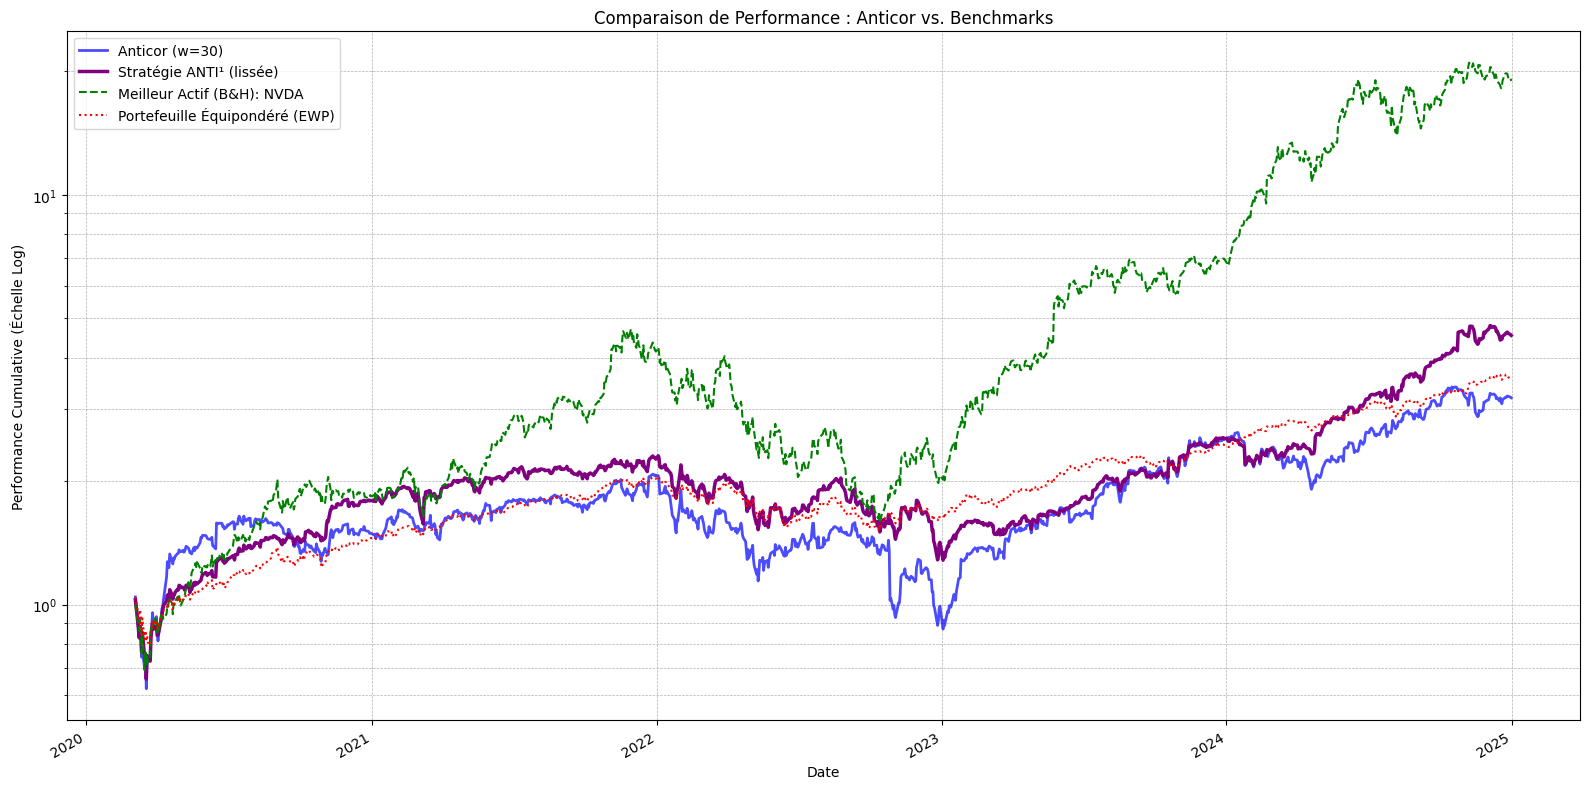

,Rendement Cumulé,Rendement Annualisé,Volatilité Annualisée,Ratio de Sharpe,Max Drawdown,Ratio de Calmar
Anticor (w=30),219.53%,27.22%,45.42%,0.60,-58.12%,0.47
ANTI¹ (lissée),353.75%,36.81%,35.97%,1.02,-44.37%,0.83
EWP,253.49%,29.91%,22.33%,1.34,-25.94%,1.15
Meilleur Actif (NVDA),1794.71%,84.07%,53.96%,1.56,-66.34%,1.27


In [ ]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
db = wrds.Connection()
end_date = '2025-01-30'
trading_days = 1276
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')
num_stocks = 25
print("✅ Connexion et paramètres définis.")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (TOP 25 S&P 500)
# =============================================================================
print("\n🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations...")
query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
end_date = last_trading_day_str
query_universe = f"""
    WITH sp500_constituents AS (SELECT permno FROM crsp.msp500list WHERE '{end_date}' BETWEEN start AND ending),
    market_cap AS (
        SELECT a.permno, ABS(a.prc * a.shrout) as mktcap
        FROM crsp.dsf AS a JOIN sp500_constituents AS b ON a.permno = b.permno
        WHERE a.date = '{end_date}' AND a.prc IS NOT NULL AND a.shrout IS NOT NULL
    )
    SELECT permno FROM market_cap ORDER BY mktcap DESC LIMIT {num_stocks}
"""
top_25_permno = db.raw_sql(query_universe)['permno'].tolist()
permno_tuple = tuple(top_25_permno)
print(f"✅ Univers de {len(top_25_permno)} actions identifié.")

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données (avec COMNAM et TICKER)...")
query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret, c.comnam, c.ticker
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    LEFT JOIN crsp.msenames AS c ON a.permno = c.permno AND a.date BETWEEN c.namedt AND c.nameendt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])
daily_data['comnam'] = daily_data.groupby('permno')['comnam'].transform(lambda x: x.ffill().bfill())
daily_data['ticker'] = daily_data.groupby('permno')['ticker'].transform(lambda x: x.ffill().bfill())
permno_to_name = daily_data.drop_duplicates('permno').set_index('permno')['comnam'].to_dict()
permno_to_ticker = daily_data.drop_duplicates('permno').set_index('permno')['ticker'].to_dict()
all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print("✅ Téléchargement terminé.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')
final_matrix_relatives.ffill(inplace=True)
final_matrix_relatives.fillna(1.0, inplace=True)
print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")


In [ ]:

# =============================================================================
# FONCTION DE STRATÉGIE ANTICOR(w) - AVEC PRINTS DE SYNTHÈSE
# =============================================================================
def run_anticor_strategy(price_relatives: pd.DataFrame, w: int, permno_to_ticker: dict, debug_days: int = 0):
    """ Exécute la stratégie ANTICOR(w) avec des prints de debug synthétiques. """
    m = price_relatives.shape[1]
    n = len(price_relatives)
    asset_permnos = price_relatives.columns
    log_relatives = np.log(price_relatives)
    
    weights_history, daily_returns_history, dates_history = [], [], []
    b_t = pd.Series(1/m, index=asset_permnos)
    
    for t in range(2 * w, n):
        is_debug_day = t < (2 * w + debug_days)

        if is_debug_day:
            print(f"\n==================== JOUR DE TRADING: {price_relatives.index[t].date()} (t={t}) ====================")
            print(f"Portefeuille utilisé pour AUJOURD'HUI (décidé hier, b_t):\n{b_t.rename(permno_to_ticker).sort_values(ascending=False).head().to_string(float_format='{:.2%}'.format)}")
            
        daily_return = (b_t * price_relatives.iloc[t]).sum() - 1
        dates_history.append(price_relatives.index[t])
        daily_returns_history.append(daily_return)
        weights_history.append(b_t.to_dict())

        b_t_rebalanced = (b_t * price_relatives.iloc[t]) / (b_t * price_relatives.iloc[t]).sum()
        
        lx1 = log_relatives.iloc[t - 2*w + 1 : t - w + 1]
        lx2 = log_relatives.iloc[t - w + 1 : t + 1]
        mu2 = lx2.mean()
        
        m_cor = pd.DataFrame(0.0, index=asset_permnos, columns=asset_permnos)
        for i in asset_permnos:
            for j in asset_permnos:
                lx1_i_std = lx1[i].std()
                lx2_j_std = lx2[j].std()
                if lx1_i_std > 1e-8 and lx2_j_std > 1e-8:
                    m_cor.loc[i, j] = np.corrcoef(lx1[i], lx2[j])[0, 1]
        
        claims = pd.DataFrame(0.0, index=asset_permnos, columns=asset_permnos)
        for i in asset_permnos:
            for j in asset_permnos:
                if i != j and mu2[i] > mu2[j] and m_cor.loc[i, j] > 0:
                    claim_val = m_cor.loc[i, j]
                    if m_cor.loc[i, i] < 0: claim_val -= m_cor.loc[i, i]
                    if m_cor.loc[j, j] < 0: claim_val -= m_cor.loc[j, j]
                    claims.loc[i, j] = claim_val
        
        total_claims_out = claims.sum(axis=1)
        b_tplus1 = b_t_rebalanced.copy()
        
        for i in asset_permnos:
            if total_claims_out[i] > 0:
                for j in asset_permnos:
                    if i != j:
                        transfer_ij = b_t_rebalanced[i] * (claims.loc[i, j] / total_claims_out[i])
                        b_tplus1[i] -= transfer_ij
                        b_tplus1[j] += transfer_ij
        
        b_t_next_day = b_tplus1 / b_tplus1.sum()

        if is_debug_day:
            print("\n--- Analyse pour le rebalancement de DEMAIN ---")
            mu2_sorted = mu2.rename(permno_to_ticker).sort_values(ascending=False)
            print(f"Top 5 Gagnants (Perf. récente élevée):\n{mu2_sorted.head().to_string(float_format='{:.4f}'.format)}")
            print(f"\nTop 5 Perdants (Perf. récente faible):\n{mu2_sorted.tail().to_string(float_format='{:.4f}'.format)}")
            
            print("\n--- Top 5 des changements de pondération effectués ---")
            weight_changes = (b_t_next_day - b_t_rebalanced).rename(permno_to_ticker)
            top_changes = weight_changes.abs().nlargest(5)
            for ticker, change in top_changes.items():
                permno = next(key for key, val in permno_to_ticker.items() if val == ticker)
                old_weight = b_t_rebalanced[permno]
                new_weight = b_t_next_day[permno]
                print(f"  - {ticker:<6}: {old_weight:.2%} -> {new_weight:.2%} (Changement: {change:+.2%})")
            print(f"\nVérification de la somme des poids pour demain: {b_t_next_day.sum():.6f}")

        b_t = b_t_next_day

    results_df = pd.DataFrame(daily_returns_history, index=dates_history, columns=['daily_profit'])
    weights_df = pd.DataFrame(weights_history, index=dates_history)
    weights_df.columns = [f'weight_{permno_to_ticker.get(col, col)}' for col in weights_df.columns]
    
    return pd.concat([results_df, weights_df], axis=1)


In [ ]:


# =============================================================================
# FONCTION POUR LA STRATÉGIE LISSÉE ANTI¹ (BAH(ANTICOR)) - CORRIGÉE
# =============================================================================

def run_anti1_strategy(price_relatives: pd.DataFrame, max_W: int, permno_to_ticker: dict):
    """
    Exécute la stratégie lissée ANTI¹ (BAH(ANTICOR)).
    Moyenne les portefeuilles de ANTICOR(w) pour w allant de 2 à max_W.
    """
    print(f"🚀 Lancement du backtest pour ANTI¹ avec W_max={max_W}...")
    
    n = len(price_relatives)
    m = price_relatives.shape[1]
    asset_names = price_relatives.columns
    
    expert_portfolios = {}
    
    for w in range(2, max_W + 1):
        print(f"  - Calcul de l'expert ANTICOR(w={w})...")
        temp_results = run_anticor_strategy(price_relatives, w, permno_to_ticker, debug_days=0) 
        
        # Calculer le profit cumulé pour cet expert (sur sa propre période de trading)
        expert_profit_cumule = (1 + temp_results['daily_profit']).prod()
        print(f"    -> Profit cumulé pour w={w} (sur sa période): {expert_profit_cumule:.4f}")
        # --- FIN DU NOUVEAU PRINT ---
        
        expert_portfolios[w] = temp_results.filter(like='weight_')

    start_date = price_relatives.index[2 * max_W]
    
    aligned_dfs = []
    for w in range(2, max_W + 1):
        df_weights = expert_portfolios[w]
        df_filtered = df_weights.loc[start_date:]
        if not df_filtered.empty:
            aligned_dfs.append(df_filtered)

    panel_df = pd.concat(aligned_dfs, keys=range(len(aligned_dfs)))
    
    # mean_weights_df a les colonnes 'weight_AAPL', 'weight_MSFT', etc.
    mean_weights_df = panel_df.groupby(level=1).mean()
    
    # S'assurer que les relatifs de prix ont aussi les tickers comme colonnes
    price_relatives_renamed = price_relatives.rename(columns=permno_to_ticker)
    
    # daily_returns_assets a les colonnes 'AAPL', 'MSFT', etc.
    daily_returns_assets = price_relatives_renamed.loc[start_date:] - 1
    
    # --- CORRECTION DU BUG ---
    # Renommer les colonnes de daily_returns_assets pour correspondre à mean_weights_df
    daily_returns_assets.columns = [f'weight_{col}' for col in daily_returns_assets.columns]
    
    # La multiplication fonctionne maintenant
    anti1_daily_returns = (mean_weights_df * daily_returns_assets).sum(axis=1)
    # --- FIN CORRECTION ---

    results_df = pd.DataFrame(anti1_daily_returns, columns=['daily_profit'])
    results_df['profit_cumule'] = (1 + results_df['daily_profit']).cumprod()
    
    results_df = results_df.join(mean_weights_df)
    
    print("✅ Backtest ANTI¹ terminé !")
    return results_df


In [ ]:


# =============================================================================
# ÉTAPE 5: EXÉCUTION DU BACKTEST ANTICOR(w=30)
# =============================================================================
print("\n🚀 Étape 5: Lancement du backtest de la stratégie Anticor(w=30)...")
resultats_strategie = run_anticor_strategy(final_matrix_relatives, w=30, permno_to_ticker=permno_to_ticker, debug_days=3)
resultats_strategie['profit_cumule'] = (1 + resultats_strategie['daily_profit']).cumprod()
print("\n✅ Backtest Anticor terminé !")


In [ ]:


# =============================================================================
# NOUVELLE ÉTAPE : EXÉCUTION DU BACKTEST ANTI¹ (W_max=30)
# =============================================================================
print("\n🚀 Lancement du backtest de la stratégie ANTI¹ (lissée)...")
resultats_anti1 = run_anti1_strategy(final_matrix_relatives, max_W=30, permno_to_ticker=permno_to_ticker)



In [ ]:

# =============================================================================
# ÉTAPE 6: CALCUL DES BENCHMARKS (MEILLEUR ACTIF ET EWP)
# =============================================================================
print("\n🚀 Étape 6: Calcul des benchmarks (Meilleur Actif et Portefeuille Équipondéré)...")

df_prix_charges = 100 * final_matrix_relatives.cumprod()
df_prix_charges.rename(columns=permno_to_ticker, inplace=True)

start_date_strat = resultats_anti1.index[0] 

# --- Meilleur Actif (Buy & Hold) ---
best_performing_ticker = df_prix_charges.iloc[-1].idxmax()
best_asset_perf = (df_prix_charges[best_performing_ticker].loc[start_date_strat:] / df_prix_charges[best_performing_ticker].loc[start_date_strat])

# --- Portefeuille Équipondéré (EWP - Equally Weighted Portfolio) ---
ewp_daily_returns = final_matrix_relatives.mean(axis=1) - 1
ewp_perf = (1 + ewp_daily_returns.loc[start_date_strat:]).cumprod()

print(f"✅ Benchmarks calculés. Meilleur actif : {best_performing_ticker}")


In [ ]:

# =============================================================================
# ÉTAPE 7: VISUALISATION ET KPIS (MISE À JOUR)
# =============================================================================
print("\n📊 Étape 7: Génération du graphique et des indicateurs de performance...")
fig, ax = plt.subplots(figsize=(16, 8))

# 1. Stratégie Anticor(w=30)
resultats_strategie['profit_cumule'].loc[start_date_strat:].plot(ax=ax, label='Anticor (w=30)', lw=2.0, color='blue', alpha=0.7)

# 2. Stratégie ANTI¹ (lissée)
resultats_anti1['profit_cumule'].plot(ax=ax, label='Stratégie ANTI¹ (lissée)', lw=2.5, color='purple')

# 3. Meilleur Actif (B&H)
best_asset_perf.plot(ax=ax, label=f'Meilleur Actif (B&H): {best_performing_ticker}', linestyle='--', color='green')

# 4. Portefeuille Équipondéré (EWP)
ewp_perf.plot(ax=ax, label='Portefeuille Équipondéré (EWP)', linestyle=':', color='red')

ax.set_title('Comparaison de Performance : Anticor vs. Benchmarks')
ax.set_ylabel('Performance Cumulative (Échelle Log)')
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Calcul et affichage des KPIs ---
def calculate_performance_metrics(daily_returns_series, risk_free_rate=0.0):
    trading_days_per_year = 252
    cumulative_return = (1 + daily_returns_series).prod() - 1
    num_days = len(daily_returns_series)
    annualized_return = (1 + cumulative_return) ** (trading_days_per_year / num_days) - 1
    annualized_volatility = daily_returns_series.std() * np.sqrt(trading_days_per_year)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility > 0 else 0
    
    cumulative_series = (1 + daily_returns_series).cumprod()
    peak = cumulative_series.expanding(min_periods=1).max()
    drawdown = (cumulative_series - peak) / peak
    max_drawdown = drawdown.min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0
    
    return {
        "Rendement Cumulé": cumulative_return, "Rendement Annualisé": annualized_return,
        "Volatilité Annualisée": annualized_volatility, "Ratio de Sharpe": sharpe_ratio,
        "Max Drawdown": max_drawdown, "Ratio de Calmar": calmar_ratio
    }

metrics = {}
metrics['Anticor (w=30)'] = calculate_performance_metrics(resultats_strategie['daily_profit'].loc[start_date_strat:])
metrics['ANTI¹ (lissée)'] = calculate_performance_metrics(resultats_anti1['daily_profit'])
metrics['EWP'] = calculate_performance_metrics(ewp_daily_returns.loc[start_date_strat:])
metrics[f'Meilleur Actif ({best_performing_ticker})'] = calculate_performance_metrics(best_asset_perf.pct_change().dropna())

results_table = pd.DataFrame(metrics).T
display(results_table.style.format({
    "Rendement Cumulé": "{:.2%}", "Rendement Annualisé": "{:.2%}",
    "Volatilité Annualisée": "{:.2%}", "Ratio de Sharpe": "{:.2f}",
    "Max Drawdown": "{:.2%}", "Ratio de Calmar": "{:.2f}"
}))